In [2]:
import os
import boto3
import io
import sagemaker

import pandas as pd
import numpy as np

from sagemaker import KMeans

In [3]:
role = sagemaker.get_execution_role()
s3_client = boto3.client("s3")
s3Bucket = "sagemaker-studio-p0xlvix7lda"

In [5]:
source_data = "s3://sagemaker-studio-p0xlvix7lda/Gold daily processed final.csv"
response = s3_client.get_object(Bucket=s3Bucket, Key="Gold daily processed final.csv")
response_body = response["Body"].read()
table = pd.read_csv(io.BytesIO(response_body), header=0, delimiter=",", low_memory=False, parse_dates=['Date'], index_col=0, usecols=['Date', 'Normalised Gold Return', 'Normalised Gold Return 2 day back 1', 'Normalised Gold Return 4 day back 3', 'Normalised Gold Return 8 day back 7', 'Var 16 day', 'Normalised S&P Return', 'Normalised S&P Return 2 day back 1', 'Normalised S&P Return 4 day back 3', 'Normalised S&P Return 8 day back 7', 'Var 16 day.1', 'Tomorrow Gold Return'])
table.head()

,Var 16 day,Normalised Gold Return,Normalised Gold Return 2 day back 1,Normalised Gold Return 4 day back 3,Normalised Gold Return 8 day back 7,Var 16 day.1,Normalised S&P Return,Normalised S&P Return 2 day back 1,Normalised S&P Return 4 day back 3,Normalised S&P Return 8 day back 7,Tomorrow Gold Return
Date,,,,,,,,,,,
2006-01-26,0.013745,-0.323525,0.359369,0.322096,0.939482,0.006625,1.092031,0.072626,-1.129939,0.401029,-0.001787
2006-01-27,0.013338,-0.133952,0.190116,0.965259,0.876347,0.006686,1.161302,0.581902,-0.647845,0.184792,0.012708
2006-01-30,0.012713,0.999577,-0.346257,0.267636,0.963565,0.006686,0.171274,1.592265,-1.184882,-0.016867,0.008837
2006-01-31,0.011519,0.767178,0.669035,0.486221,0.245949,0.006339,-0.627284,0.994861,0.771635,-1.239087,-0.002453
2006-02-01,0.010985,-0.223273,1.394069,0.032610,0.827823,0.006281,0.296037,-0.319243,1.253555,-1.129202,0.005444


In [29]:
hist_bincount = 48

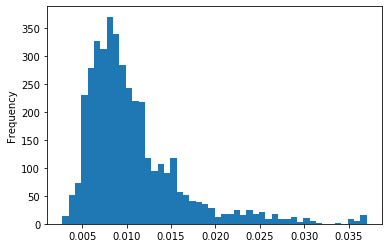

In [30]:
table['Var 16 day'].plot.hist(bins=hist_bincount)

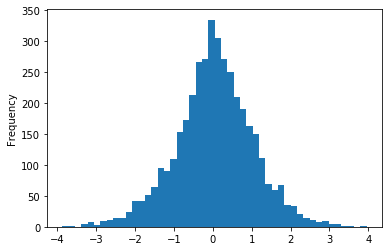

In [31]:
table['Normalised Gold Return'].plot.hist(bins=hist_bincount)

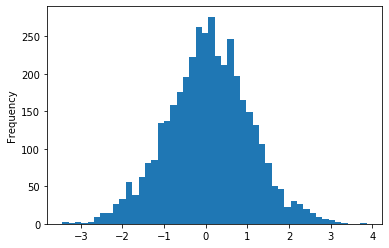

In [32]:
table['Normalised Gold Return 2 day back 1'].plot.hist(bins=hist_bincount)

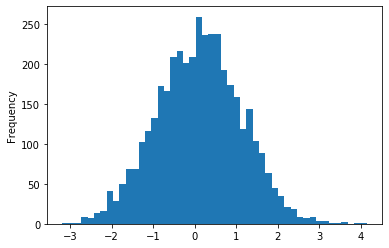

In [33]:
table['Normalised Gold Return 4 day back 3'].plot.hist(bins=hist_bincount)

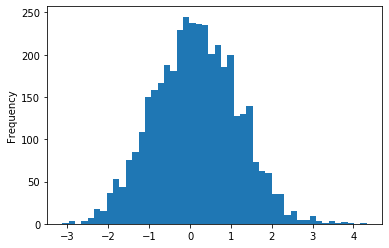

In [34]:
table['Normalised Gold Return 8 day back 7'].plot.hist(bins=hist_bincount)

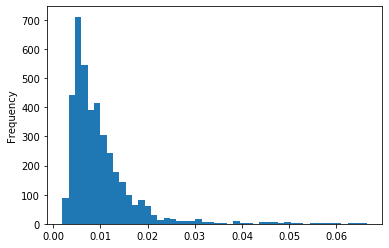

In [35]:
table['Var 16 day.1'].plot.hist(bins=hist_bincount)

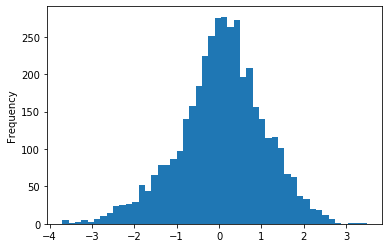

In [36]:
table['Normalised S&P Return'].plot.hist(bins=hist_bincount)

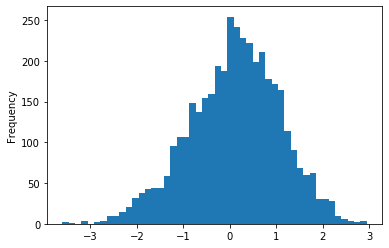

In [37]:
table['Normalised S&P Return 2 day back 1'].plot.hist(bins=hist_bincount)

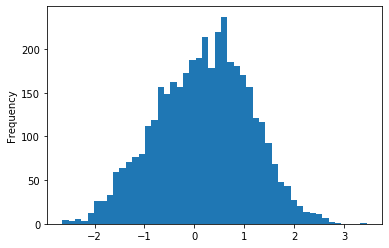

In [38]:
table['Normalised S&P Return 4 day back 3'].plot.hist(bins=hist_bincount)

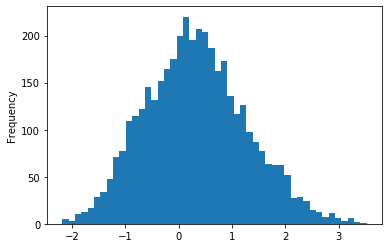

In [39]:
table['Normalised S&P Return 8 day back 7'].plot.hist(bins=hist_bincount)

In [6]:
trainTableNew = table.loc[:"2017-12-26",:]
testTableNew  = table.loc["2017-12-27":,:]

In [7]:
kMeansTable = table[['Normalised Gold Return', 'Normalised Gold Return 2 day back 1', 'Normalised Gold Return 4 day back 3', 'Normalised Gold Return 8 day back 7', 'Var 16 day', 'Normalised S&P Return', 'Normalised S&P Return 2 day back 1', 'Normalised S&P Return 4 day back 3', 'Normalised S&P Return 8 day back 7', 'Var 16 day.1']]
trainKMeansTableNew = kMeansTable.iloc[:3000,:]
testKMeansTableNew = kMeansTable.iloc[3000:,:]

In [8]:
trainKMeansTableNew.shape

(3000, 10)

In [9]:
testKMeansTableNew.shape

(992, 10)

In [10]:
num_clusters = 6
from sagemaker import KMeans

kmeans = KMeans(
    role=role,
    instance_count=1,
    instance_type="ml.c4.xlarge",
    output_path="s3://" + s3Bucket + "/groups/",
    k=num_clusters,
)


In [11]:
kmeans.fit(kmeans.record_set(trainKMeansTableNew.values.astype("float32")))

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


2021-12-27 21:18:45 Starting - Starting the training job...
2021-12-27 21:19:09 Starting - Launching requested ML instancesProfilerReport-1640639925: InProgress
......
2021-12-27 21:20:10 Starting - Preparing the instances for training......
2021-12-27 21:21:15 Downloading - Downloading input data
2021-12-27 21:21:15 Training - Downloading the training image.........
2021-12-27 21:22:43 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/27/2021 21:22:47 INFO 140702524630848] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'init_method': 'random', 'mini_batch_size': '5000', 'epochs': '1', 'extra_center_factor': 'auto', 'local_lloyd_max_iter': '300', 'local_lloyd_tol': '0.0001', 'local_lloyd_init_method': 'kmeans++', 'local_lloyd_num_trials': 'auto', 'half_life_time_size': '0', 'eval_metrics': '["msd"]',

In [12]:
kmeans_predictor = kmeans.deploy(initial_instance_count=1, instance_type="ml.t2.medium")

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


--------------!

In [13]:
trainResult = kmeans_predictor.predict(trainKMeansTableNew.values.astype("float32"))

In [14]:
testResult = kmeans_predictor.predict(testKMeansTableNew.values.astype("float32"))

In [15]:
kmeans_predictor.delete_endpoint()

In [16]:
trainResultList = [int(i.label["closest_cluster"].float32_tensor.values[0]) for i in trainResult]
trainTableNew['Cluster'] = trainResultList
trainTableNew.head()
trainTableNew.to_csv("data/clusteredTrain.csv")
[trainTableNew[trainTableNew['Cluster']==i].to_csv("data/train" + str(i) + ".csv") for i in np.unique(trainTableNew['Cluster'].values.ravel())]
trainTableClustered = [trainTableNew[trainTableNew['Cluster']==i] for i in np.unique(trainTableNew['Cluster'].values.ravel())]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [17]:
testResultList = [int(i.label["closest_cluster"].float32_tensor.values[0]) for i in testResult]
testTableNew['Cluster'] = testResultList
testTableNew.head()
testTableNew.to_csv("data/clusteredTest.csv")
[testTableNew[testTableNew['Cluster']==i].to_csv("data/test" + str(i) + ".csv") for i in np.unique(testTableNew['Cluster'].values.ravel())]
testTableClustered = [testTableNew[testTableNew['Cluster']==i] for i in np.unique(testTableNew['Cluster'].values.ravel())]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [18]:
trainTableClustered[0].head()

,Var 16 day,Normalised Gold Return,Normalised Gold Return 2 day back 1,Normalised Gold Return 4 day back 3,Normalised Gold Return 8 day back 7,Var 16 day.1,Normalised S&P Return,Normalised S&P Return 2 day back 1,Normalised S&P Return 4 day back 3,Normalised S&P Return 8 day back 7,Tomorrow Gold Return,Cluster
Date,,,,,,,,,,,,
2006-02-07,0.013692,-2.459206,-0.207471,0.901968,0.247293,0.006718,-1.204875,-0.482011,-0.746715,0.028301,-0.001633,0
2006-02-13,0.015017,-1.355534,0.008560,-1.302734,0.598810,0.005269,-0.618598,0.142072,-0.387506,0.372682,0.012801,0
2006-03-06,0.013526,-1.449860,0.231927,1.017815,-0.085512,0.005797,-1.202088,-0.378811,0.231070,1.001256,-0.003965,0
2006-03-08,0.011709,-1.576071,-1.419010,0.869872,0.486732,0.005734,0.354003,-1.087281,-0.464228,0.898588,0.005530,0
2006-04-07,0.010198,-1.120341,1.088628,1.112405,1.182586,0.004998,-2.069570,0.336930,0.233427,-0.235938,0.015636,0


In [45]:
import sagemaker

# Helper wrappers referred earlier
from ag_model import (
    AutoGluonTraining,
    AutoGluonInferenceModel,
    AutoGluonTabularPredictor,
)
from sagemaker import utils

role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.session.Session()
region = sagemaker_session._region_name

bucket = sagemaker_session.default_bucket()
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
output_path = f"s3://{bucket}/{s3_prefix}/output/"


In [51]:
ag = AutoGluonTraining(
    role=role,
    entry_point="scripts/hpo.py",
    region=region,
    instance_count=1,
    instance_type="ml.m5.2xlarge",
    framework_version="0.3.1",
    base_job_name="autogluon-tabular-train",
)


In [52]:
s3_prefix = f"autogluon_sm/{utils.sagemaker_timestamp()}"
train_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "train0.csv"), key_prefix=s3_prefix
)
eval_input = ag.sagemaker_session.upload_data(
    path=os.path.join("data", "test0.csv"), key_prefix=s3_prefix
)
config_input = ag.sagemaker_session.upload_data(
    path=os.path.join("ag_configs", "config-full.yaml"), key_prefix=s3_prefix
)

job_name = utils.unique_name_from_base("test-autogluon-image")
ag.fit(
    {"config": config_input, "train": train_input, "test": eval_input},
    job_name=job_name,
)


2021-12-27 23:18:42 Starting - Starting the training job...
2021-12-27 23:19:09 Starting - Launching requested ML instancesProfilerReport-1640647122: InProgress
......
2021-12-27 23:20:09 Starting - Preparing the instances for training......
2021-12-27 23:21:09 Downloading - Downloading input data...
2021-12-27 23:21:29 Training - Downloading the training image...
2021-12-27 23:22:10 Training - Training image download completed. Training in progress.2021-12-27 23:21:59,409 sagemaker-training-toolkit INFO     Imported framework sagemaker_mxnet_container.training
2021-12-27 23:21:59,411 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2021-12-27 23:21:59,422 sagemaker_mxnet_container.training INFO     MXNet training environment: {'SM_HOSTS': '["algo-1"]', 'SM_NETWORK_INTERFACE_NAME': 'eth0', 'SM_HPS': '{}', 'SM_USER_ENTRY_POINT': 'hpo.py', 'SM_FRAMEWORK_PARAMS': '{}', 'SM_RESOURCE_CONFIG': '{"current_host":"algo-1","hosts":["algo-1"],"network_interface_n

In [59]:
endpoint_name = sagemaker.utils.unique_name_from_base("sagemaker-autogluon-serving-trained-model")
model_data = 's3://' + os.path.join(sagemaker_session.default_bucket(), job_name, 'output', 'model.tar.gz')

In [61]:
from sagemaker.serializers import CSVSerializer
instance_type = "ml.m5.2xlarge"

model = AutoGluonInferenceModel(
    model_data=model_data,
    role=role,
    region=region,
    framework_version="0.3.1",
    instance_type=instance_type,
    source_dir="scripts",
    entry_point="hpo.py",
)

predictor = model.deploy(
    initial_instance_count=1, serializer=CSVSerializer(), instance_type=instance_type
)


-----!

In [70]:

results = predictor.predict(testTableClustered[0].drop(columns=['Cluster']).to_csv(index=False, header=False))

In [74]:
len(results)

99

In [81]:
res=[]
res.append(results)

In [82]:
res

[[[2.5483670469839126e-05, 2.5483670469839126e-05],
  [-0.00026638907729648054, -0.00026638907729648054],
  [-0.0016387288924306631, -0.0016387288924306631],
  [-0.0015963999321684241, -0.0015963999321684241],
  [-0.000770609243772924, -0.000770609243772924],
  [-0.0010848644888028502, -0.0010848644888028502],
  [-0.0017359096091240644, -0.0017359096091240644],
  [-0.0006679323269054294, -0.0006679323269054294],
  [-0.00022823756444267929, -0.00022823756444267929],
  [-0.0005692045670002699, -0.0005692045670002699],
  [-0.0009111722465604544, -0.0009111722465604544],
  [-0.0009386855526827276, -0.0009386855526827276],
  [-0.0020370616111904383, -0.0020370616111904383],
  [-0.00046790781198069453, -0.00046790781198069453],
  [-0.0006766841397620738, -0.0006766841397620738],
  [-0.0007759048021398485, -0.0007759048021398485],
  [-0.0012591436970978975, -0.0012591436970978975],
  [-0.001007281243801117, -0.001007281243801117],
  [-0.0010681756539270282, -0.0010681756539270282],
  [6.36933

In [75]:
predictor.delete_endpoint()

In [ ]:
#
#model_key = "groups/" + kmeans.latest_training_job.name + "/output/model.tar.gz"
#boto3.resource("s3").Bucket(bucket).download_file(model_key, "model.tar.gz")
#os.system("tar -zxvf model.tar.gz")
#Kmeans_model_params = mx.ndarray.load("model_algo-1")
#cluster_centroids = pd.DataFrame(Kmeans_model_params[0].asnumpy())
#cluster_centroids.columns = counties_transformed.columns
#